# Pythonでゴブレットゴブラーズ(簡易)の解析

- ゴブレットゴブラーズ [本家(Blue Orange Games)](https://www.blueorangegames.com/index.php/games/gobbletgobblers) / [日本(すごろくや)](https://sgrk.blog.fc2.com/blog-entry-3687.html) 
- [ソースコード設計スライド](https://docs.google.com/presentation/d/1K8fbRlk24Y_J3M--F-WnYYN0hddL89w3EGN4Zgw-L1g/edit?usp=sharing)
- [卒論概要](https://docs.google.com/document/d/1jEXvVmpUPCaowl3xR1qgyhUFGVHFVzyZjBo9F8OAR7M/edit?usp=sharing)

## 1. 設計

### a) state

必要な情報を36bitで表す。  
state = 0b_000000000_000000000_000000000_000000000


| 区分 | my_large_board | my_middle_board | your_large_board | your_middle_board |
| ---- | ---- | ---- | ---- | ---- |
| bit数 | 9bit | 9bit | 9bit | 9bit |
| 例 | 100000000 | 010000000 | 001000000 | 001010000 | 
| 説明 | 盤面に置いてある自L駒 | 盤面に置いてある自M駒 | 盤面に置いてある敵L駒 | 盤面に置いてある敵L駒 |

手番交代では、上位bit半分と下位bit半分を入れ替える。
```
change_player_state  = 
(state & 0b_111111111_111111111_000000000_000000000) >> 18 | (state & 0b_000000000_000000000_111111111_111111111) << 18
```

確認

In [753]:
# 確認
state = 0b_000000000_000000000_000000000_000000000
print(state) # 10進数
print(f'{state:036b}')#bin(プレフィックスなし)
print(type(f'{state:036b}')) #文字列です
print(len(f'{state:036b}')) # bit数の確認

0
000000000000000000000000000000000000
<class 'str'>
36


bit操作

In [754]:
state =  0b_111000000_000111000_000000111_000000000
print("プレイヤー変更前 : " + f'{state:036b}')
# 敵と味方の駒を入れ替える
state  = (state & 0b_111111111_111111111_000000000_000000000) >> 18 | (state & 0b_000000000_000000000_111111111_111111111) << 18
print("プレイヤー変更後 : " + f'{state:036b}')

プレイヤー変更前 : 111000000000111000000000111000000000
プレイヤー変更後 : 000000111000000000111000000000111000


複数bitの取り出しチャンク

In [755]:
state = 0b_111000000_000111000_000000111_000000000
print("状態   : " +  f'{state:036b}')

# 文字列でバラす
my_large_board = f'{state:036b}'[0:9]
my_middle_board = f'{state:036b}'[9:18]
your_large_board = f'{state:036b}'[18:27]
your_middle_board = f'{state:036b}'[27:36]
print("\n文字列で操作")
print("再構築 : " + my_large_board + my_middle_board + your_large_board + your_middle_board)

# bitで取り出す
my_large_board = (state & 0b_111111111_000000000_000000000_000000000) >> 27
my_middle_board = (state & 0b_000000000_111111111_000000000_000000000) >> 18
your_large_board = (state & 0b_000000000_000000000_111111111_000000000) >> 9
your_middle_board = state & 0b_000000000_000000000_000000000_111111111
print("\nbitで取り出す")
print(f"my_large_board : {my_large_board}")
print(f"my_middle_board : {my_middle_board}")
print(f"your_large_board : {your_large_board}")
print(f"your_middle_board : {your_middle_board}")
state = (my_large_board << 27) | (my_middle_board << 18) | (your_large_board << 9) | your_middle_board
print("再構築 : " + f"{state:036b}")

状態   : 111000000000111000000000111000000000

文字列で操作
再構築 : 111000000000111000000000111000000000

bitで取り出す
my_large_board : 448
my_middle_board : 56
your_large_board : 7
your_middle_board : 0
再構築 : 111000000000111000000000111000000000


#### handの作成

hand = (自Lの個数, 自Mの個数, 敵Lの個数, 敵Mの個数)

In [1]:
hand_1_table = [0b100000000, 0b010000000, 0b001000000, 0b000100000, 0b000010000, 0b000001000, 0b000000100, 0b000000010, 0b000000001]

def create_hand(state):
    hand = [2, 2, 2, 2]
    num_of_piece_type = [0,0,0,0] # my_large_board, my_middle_board, your_large_board, your_middle_board
    num_of_piece_type[0] = (state & 0b_111111111_000000000_000000000_000000000) >> 27
    num_of_piece_type[1] = (state & 0b_000000000_111111111_000000000_000000000) >> 18
    num_of_piece_type[2] = (state & 0b_000000000_000000000_111111111_000000000) >> 9
    num_of_piece_type[3] = state & 0b_000000000_000000000_000000000_111111111
    
    for i in range(4):
        if num_of_piece_type[i] != 0:
            hand[i] = 1 if num_of_piece_type[i] in hand_1_table else 0
    return hand

In [757]:
# 確認
state = 0b01001000010000000000000000000001100
print(create_hand(state))

[0, 1, 2, 0]


### b) action

必要な情報を20bitで表す。  
action = 0b_0_0_000000000_000000000

| 区分 | piece_size | is_hand | before_moving_piece_axis | after_moving_piece_axis |
| ---- | ---- | ---- | ---- | ---- | 
| bit数 | 1bit | 1bit | 9bit | 9bit |
| 例 | 1 | 1 | 000000000 | 100000000 |
| 説明 | 行動する駒の大きさ. 0ならL, 1ならM | 手駒かどうか. 手駒なら1 | 移動元の駒の位置 | 移動先の駒の位置 |

- 行動する駒の大きさ, 移動元の駒の位置, 移動先の駒の位置

確認

In [758]:
# 確認
action = 0b_1_0_001000000_000000001
print(action) # 10進数
print(f'{action:020b}')#bin(プレフィックスなし)
print(type(f'{action:020b}')) #文字列です
print(len(f'{action:020b}')) # bit数の確認

557057
10001000000000000001
<class 'str'>
20


bit操作

複数bitの取り出しチャンク

In [759]:
action = 0b_1_0_001000000_000000001
print("行動   : " +  f'{action:020b}')

# 文字列でバラす
piece_size = f'{action:020b}'[0]
is_hand = f'{action:020b}'[1]
before_moving_piece_axis = f'{action:020b}'[2:11]
after_moving_piece_axis = f'{action:020b}'[11:20]
print("\n文字列で操作")
print("再構築 : " + piece_size + is_hand + before_moving_piece_axis + after_moving_piece_axis)

# bitで取り出す
piece_size = (action & 0b_1_0_000000000_000000000) >> 19
is_hand = (action & 0b_0_1_000000000_000000000) >> 18
before_moving_piece_axis = (action & 0b_0_0_111111111_000000000) >> 9
after_moving_piece_axis = action & 0b_0_0_000000000_111111111
print("\nbitで取り出す")
print(f"piece_size : {piece_size}")
print(f"is_hand : {is_hand}")
print(f"before_moving_piece_axis : {before_moving_piece_axis:036b}")
print(f"after_moving_piece_axis  : {after_moving_piece_axis:036b}")
state = (piece_size << 19) | (is_hand << 18) | (before_moving_piece_axis << 9) | after_moving_piece_axis
print("再構築 : " + f'{action:020b}')

行動   : 10001000000000000001

文字列で操作
再構築 : 10001000000000000001

bitで取り出す
piece_size : 1
is_hand : 0
before_moving_piece_axis : 000000000000000000000000000001000000
after_moving_piece_axis  : 000000000000000000000000000000000001
再構築 : 10001000000000000001


## 関数宣言

### 正規化

盤面を回転、線対称、点対称させることで、同意の状態を一つの状態として扱う。  
変換後、board部が最も小さい状態で正規化する。

In [2]:
# 8つの変換関数
def horizonal(state):
    return (state & 0b_111000000_111000000_111000000_111000000) >> 6 | (state & 0b_000111000_000111000_000111000_000111000) | (state & 0b_000000111_000000111_000000111_000000111) << 6

def vertical(state):
    return (state & 0b_100100100_100100100_100100100_100100100) >> 2 | (state & 0b_010010010_010010010_010010010_010010010) | (state & 0b_001001001_001001001_001001001_001001001) << 2

def rotate90(state):
    return (state & 0b_100001000_100001000_100001000_100001000) >> 2 | (state & 0b_010000000_010000000_010000000_010000000) >> 4 | (state & 0b_001000000_001000000_001000000_001000000) >> 6 |(state & 0b_000100001_000100001_000100001_000100001) << 2 | (state & 0b_000010000_000010000_000010000_000010000) | (state & 0b_000000100_000000100_000000100_000000100) << 6 | (state & 0b_000000010_000000010_000000010_000000010) << 4 

def rotate180(state):
    state = (state & 0b_111100000_111100000_111100000_111100000) >> 5 | (state & 0b_000010000_000010000_000010000_000010000) | (state & 0b_000001111_000001111_000001111_000001111) << 5
    state = (state & 0b_110001100_110001100_110001100_110001100) >> 2 | (state & 0b_000010000_000010000_000010000_000010000) | (state & 0b_001100011_001100011_001100011_001100011) << 2
    state = (state & 0b_101001010_101001010_101001010_101001010) >> 1 | (state & 0b_000010000_000010000_000010000_000010000) | (state & 0b_010100101_010100101_010100101_010100101) << 1
    return state

def rotate270(state):
    state = rotate180(state)
    state = rotate90(state)
    return state

def line048(state):
    state = vertical(state)
    state = rotate90(state)
    return state

def line246(state):
    state = horizonal(state)
    state = rotate90(state)
    return state

In [3]:
state = 0b_111000000_000000000_000000000_000000000
print(f"{state:036b}")
print(f"{horizonal(state):036b}")
print(f"{vertical(state):036b}")
print(f"{rotate90(state):036b}")
print(f"{rotate180(state):036b}")
print(f"{rotate270(state):036b}")
print(f"{line048(state):036b}")
print(f"{line246(state):036b}")

111000000000000000000000000000000000
000000111000000000000000000000000000
111000000000000000000000000000000000
001001001000000000000000000000000000
000000111000000000000000000000000000
100100100000000000000000000000000000
001001001000000000000000000000000000
100100100000000000000000000000000000


In [4]:
def convert_normalization_state(state):
    # 変換して最も小さい状態で正規化する
    cand_state = [state, horizonal(state), vertical(state), rotate90(state), rotate180(state), rotate270(state), line048(state), line246(state)]
    return min(cand_state)

確認

In [763]:
# 確認
state = 0b_111000000_000000000_000000000_000000000
print(f"{state:036b}")
print(f"{convert_normalization_state(state):036b}")

111000000000000000000000000000000000
000000111000000000000000000000000000


### 合法手

stateからその合法手一覧であるactionsを作成する
ただし、駒を持ち上げた時の勝敗はcreate_next_stateで判定する。
つまり、指したら持ち上げた段階で負け、次の状態に遷移できない手も作成する。
アクションとしては合法だが、到達しない状態へ遷移するので注意。

actions:
```
actions = [action1, action2, ...]
```

actionを2回に分けて作成
- 行動できる駒一覧を作成する。 : can_choising_pieces(state)
- その駒を置ける場所一覧を作成する : can_setting_axis(state)

 #### can_choising_pieces(state) :
 
 - before_action... actionの下位bit after_moving_piece_axis 以外を出力

In [5]:
def can_choising_pieces(state):
    choising_pieces = []
    # 手駒が動かせるか
    hand = create_hand(state)
    if hand[0] != 0:
        choising_pieces.append(0b_0_1_000000000)
    if hand[1] != 0:
        choising_pieces.append(0b_1_1_000000000)
    # 盤駒が動かせるか
    my_large_board = (state & 0b_111111111_000000000_000000000_000000000) >> 27
    my_middle_board = (state & 0b_000000000_111111111_000000000_000000000) >> 18
    your_large_board = (state & 0b_000000000_000000000_111111111_000000000) >> 9
    large_mask = my_large_board | your_large_board # L駒が置いてあるマスが1
    
    # not_covered_my_middle_board = my_middle_board & ~large_mask # 上に駒がない自M駒
    
    large_mask_str = f"{large_mask:09b}"
    my_middle_board_str_list = list(f"{my_middle_board:09b}")
    for i, bit in enumerate(large_mask_str):
        if bit == "1":
            my_middle_board_str_list[i] == "0"
    
    not_covered_my_middle_board = int("".join(my_middle_board_str_list), 2)
            
    
    
    for i in range(9): # 各マス確認
        # マスの自L駒
        if my_large_board & 1 == 1:
            choising_pieces.append(2**i)
        my_large_board = my_large_board >> 1
        # マスの自M駒
        if not_covered_my_middle_board & 1 == 1:
            choising_pieces.append(0b_1_0_000000000 | 2**i)
        not_covered_my_middle_board = not_covered_my_middle_board >> 1
    return choising_pieces

In [6]:
# 確認
state = 0b100000000_000100000_000000000_000000000
for action in can_choising_pieces(state):
    print(f"{action:011b}")

01000000000
11000000000
10000100000
00100000000


#### can_setting_axis(before_action)

before_actionからafter_moving_piece_axesを作成する。注意！複数系

after_moving_piece_axes = [after_moving_piece_axis1, after_moving_piece_axis2, ...]

In [7]:
def can_setting_axis(before_action, state):
    piece_size = (before_action & 0b_1_0_000000000) >> 10
    is_hand = (before_action & 0b_0_1_000000000) >> 9
    before_moving_piece_axis = (before_action & 0b_0_0_111111111)
    # Lがあるところにはおけない、MがあるところにL以外置けない, 空なら置ける。
    my_large_board = (state & 0b_111111111_000000000_000000000_000000000) >> 27
    my_middle_board = (state & 0b_000000000_111111111_000000000_000000000) >> 18
    your_large_board = (state & 0b_000000000_000000000_111111111_000000000) >> 9
    your_middle_board = state & 0b_000000000_000000000_000000000_111111111
    large_mask = my_large_board | your_large_board # L駒が置いてあるマスが1
    middle_mask = my_middle_board | your_middle_board # M駒が置いてあるマスが1
    exist_mask = large_mask | middle_mask
    
    after_moving_piece_axes = []
    for i in range(9): # 各マス確認
        if (is_hand != 1) and (before_moving_piece_axis == 2**i): # 元あったマスにはおけない。
                pass;
        elif piece_size == 0: # L駒なら
            # L駒が置いていないなら置ける
            if large_mask & 1 == 0:
                after_moving_piece_axes.append(2**i)
        else: # M駒なら
            # L, M駒が置いていないなら置ける
            if exist_mask & 1 == 0:
                after_moving_piece_axes.append(2**i)
            
        large_mask = large_mask >> 1
        exist_mask = exist_mask >> 1
    return after_moving_piece_axes


In [8]:
# 確認
state = 0b_110000000_010000001_001100000_001010000
print(f"state:{state:036b}")
for choising_piece in can_choising_pieces(state):
    piece_size_str = "L" if choising_piece >> 10 == 0 else "M"
    is_hand_str = "持ち駒" if (choising_piece & 0b_0_1_000000000) >> 9 == 1 else "盤上の駒, マス"
    before_moving_piece_axis = (choising_piece & 0b_0_0_111111111)
    mass = ""
    if is_hand_str == "盤上の駒, マス":
        mass = [256, 128, 64, 32, 16, 8, 4, 2, 1].index(before_moving_piece_axis)
    print(f"choise:  size ... {piece_size_str}, place ... {is_hand_str} {mass}")
    for axis in can_setting_axis(choising_piece, state):
        print(f"行動 {axis:09b}")

state:110000000010000001001100000001010000
choise:  size ... M, place ... 盤上の駒, マス 8
行動 000000010
行動 000000100
行動 000001000
choise:  size ... L, place ... 盤上の駒, マス 1
行動 000000001
行動 000000010
行動 000000100
行動 000001000
行動 000010000
choise:  size ... M, place ... 盤上の駒, マス 1
行動 000000010
行動 000000100
行動 000001000
choise:  size ... L, place ... 盤上の駒, マス 0
行動 000000001
行動 000000010
行動 000000100
行動 000001000
行動 000010000


#### 合法手の作成

In [9]:
def legal_actions(state):
    actions = []
    for before_action in can_choising_pieces(state):
        for after_moving_piece_axis in can_setting_axis(before_action, state):
            actions.append(before_action << 9 | after_moving_piece_axis)
    return actions

確認

In [10]:
# 確認

# 先手, 手駒Lを選択時, 置ける駒はL, その位置は0~8のハズ
state = 0b_000000000_000000000_000000000_000000000
print(len(legal_actions(state)))

18


### 次の手

stateにactionを反映して、次のstateを作成する

next_stateを2回に分けて作成。  
- 駒を持ち上げた状態を作成 : create_next_state_from_choise(state, action)
- 駒を持ち上げて置いた状態を作成 : create_next_state_from_set(state, action)


#### 駒を持ち上げた状態を作成

In [11]:
# bit反転がうまくいかなかった。用解析。
# 苦肉の策で文字列でbit操作をしている。

def create_next_state_from_choise(state, action):
    next_state = state
    is_hand = (action & 0b_0_1_000000000_000000000) >> 18
    if is_hand != 1: # 盤面なら、重なった部分を0にする
        piece_size = (action & 0b_1_0_000000000_000000000) >> 19
        before_moving_piece_axis =f"{(action & 0b_0_0_111111111_000000000) >> 9:09b}"
        
        my_large_board = list(f'{state:036b}'[0:9])
        my_middle_board = list(f'{state:036b}'[9:18])
        your_large_board = list(f'{state:036b}'[18:27])
        your_middle_board = list(f'{state:036b}'[27:36])

        if piece_size == 0: # L駒なら
            for i in range(9):
                if before_moving_piece_axis[i] == "1":
                    my_large_board[i] = "0"
        else: # M駒なら
            for i in range(9):
                if before_moving_piece_axis[i] == "1":
                    my_middle_board[i] = "0"

        next_state = int("".join(my_large_board) + "".join(my_middle_board) + "".join(your_large_board) + "".join(your_middle_board), 2)
    return next_state

In [12]:
# 確認
state = 0b_100000000_010000000_000000000_000000000
print("手L駒")
action = 0b_0_1_000000000_000000000
next_state =  create_next_state_from_choise(state, action)
print(f"{state:036b}")
print(f"{next_state:036b}")
print("手M駒")
action = 0b_1_1_000000000_000000000
next_state =  create_next_state_from_choise(state, action)
print(f"{state:036b}")
print(f"{next_state:036b}")
print("盤L駒")
action = 0b_0_0_100000000_000000000
next_state =  create_next_state_from_choise(state, action)
print(f"{state:036b}")
print(f"{next_state:036b}")
print("盤M駒")
action = 0b_1_0_010000000_000000000
next_state =  create_next_state_from_choise(state, action)
print(f"{state:036b}")
print(f"{next_state:036b}")


手L駒
100000000010000000000000000000000000
100000000010000000000000000000000000
手M駒
100000000010000000000000000000000000
100000000010000000000000000000000000
盤L駒
100000000010000000000000000000000000
000000000010000000000000000000000000
盤M駒
100000000010000000000000000000000000
100000000000000000000000000000000000


#### 持ち上げた駒を置いた状態を作成

- stateはすでにcreate_next_state_from_choiseが反映されているとする。

In [13]:
def create_next_state_from_set(state, action):
    next_state = state
    piece_size = (action & 0b_1_0_000000000_000000000) >> 19
    after_moving_piece_axis = action & 0b_0_0_000000000_111111111
    # print(after_moving_piece_axis)
    # print(piece_size)
    if piece_size == 0: #L駒
        next_state = next_state | (after_moving_piece_axis << 27) 
    else: # M駒
        next_state = next_state | (after_moving_piece_axis << 18)

    return next_state

In [14]:
# 確認
state = 0b100000000100000000000000000000000000
print("手L駒")
action = 0b_0_1_000000000_000000001
next_state =  create_next_state_from_choise(state, action)
print(f"{state:036b}")
print(f"{next_state:036b}")
next_state = create_next_state_from_set(next_state, action)
print(f"{next_state:036b}")

print("手M駒")
action = 0b_1_1_000000000_000000001
next_state =  create_next_state_from_choise(state, action)
print(f"{state:036b}")
print(f"{next_state:036b}")
next_state = create_next_state_from_set(next_state, action)
print(f"{next_state:036b}")

print("盤L駒")
action = 0b_0_0_100000000_000000001
next_state =  create_next_state_from_choise(state, action)
print(f"{state:036b}")
print(f"{next_state:036b}")
next_state = create_next_state_from_set(next_state, action)
print(f"{next_state:036b}")

print("盤M駒")
action = 0b_1_0_100000000_000000001
next_state =  create_next_state_from_choise(state, action)
print(f"{state:036b}")
print(f"{next_state:036b}")
next_state = create_next_state_from_set(next_state, action)
print(f"{next_state:036b}")


手L駒
100000000100000000000000000000000000
100000000100000000000000000000000000
100000001100000000000000000000000000
手M駒
100000000100000000000000000000000000
100000000100000000000000000000000000
100000000100000001000000000000000000
盤L駒
100000000100000000000000000000000000
000000000100000000000000000000000000
000000001100000000000000000000000000
盤M駒
100000000100000000000000000000000000
100000000000000000000000000000000000
100000000000000001000000000000000000


In [15]:
# actionから次の状態を直接作成(set -> set)
def create_next_state(state, action):
    next_choise_state = create_next_state_from_choise(state, action)
    next_set_state = create_next_state_from_set(next_choise_state, action)
    return next_set_state

### 盤面から勝敗確定かチェック

check_result(state) -> [is_done, winner]:

- is_done : 勝敗確定盤面か
- winner : 自分の勝ちなら0, 相手の勝ちなら1

surface_board
 … boardで上に駒が重なっている駒を0にした。



In [16]:
# 勝敗の有無

# 確かめるマスの座標 = [[0,1,2], [3,4,5], [6,7,8], [0,3,6], [1,4,7], [2,5,8], [0,4,8], [2,4,6]]
check_masks = [0b111000000, 0b000111000, 0b000000111, 0b100100100, 0b010010010, 0b001001001, 0b100010001, 0b001010100]

def is_win(single_surface):
    for check_mask in check_masks:
        if (single_surface & check_mask) == check_mask:
            return True
    return False

In [17]:
# 確認
single_surface = 0b000000000
print(is_win(single_surface))
single_surface = 0b100000000
print(is_win(single_surface))
single_surface = 0b110000000
print(is_win(single_surface))
single_surface = 0b101111000
print(is_win(single_surface))

False
False
False
True


In [18]:
# 表面の駒だけbitが立つboardを作成する
def create_surface(state):    
    # LがあるところのMを0にする
    my_large_board = (state & 0b_111111111_000000000_000000000_000000000) >> 27
    my_middle_board = (state & 0b_000000000_111111111_000000000_000000000) >> 18
    your_large_board = (state & 0b_000000000_000000000_111111111_000000000) >> 9
    your_middle_board = state & 0b_000000000_000000000_000000000_111111111

    large_mask = my_large_board | your_large_board # L駒が置いてあるマスが1
    
    # mask = (large_mask << 18) | large_mask # state = 0b110000000_000000000...0 なら mask = 0b110000000_000000000_000000000

    my_large_board = list(f'{state:036b}'[0:9])
    my_middle_board = list(f'{state:036b}'[9:18])
    your_large_board = list(f'{state:036b}'[18:27])
    your_middle_board = list(f'{state:036b}'[27:36])

    for i, bit in enumerate(f"{large_mask:09b}"):
        if bit == "1":
            my_middle_board[i] == "0"
            your_middle_board[i] == "0"

    state_surface = int("".join(my_large_board) + "".join(my_middle_board) + "".join(your_large_board) + "".join(your_middle_board), 2)

    return state_surface

In [19]:
# 確認
state = 0b_110000000_011000000_001100000_000110000
print(f"{create_surface(state):036b}")

110000000011000000001100000000110000


In [20]:
#勝敗の有無、勝者を確認する
def check_result(state):
    state_surface = create_surface(state)
    is_done = 0 # 決着がついているなら1を返す
    winner = 0 # 自分は0, 相手は1
    # 内部で自駒と敵駒をそれぞれ一つにまとめる
    single_surfaces = [0, 0]
    my_large_board = (state_surface & 0b_111111111_000000000_000000000_000000000) >> 27
    my_middle_board = (state_surface & 0b_000000000_111111111_000000000_000000000) >> 18
    your_large_board = (state_surface & 0b_000000000_000000000_111111111_000000000) >> 9
    your_middle_board = state_surface & 0b_000000000_000000000_000000000_111111111
    single_surfaces[0] = my_large_board | my_middle_board
    single_surfaces[1] = your_large_board | your_middle_board
    
    is_my_win = is_win(single_surfaces[0])
    is_your_win = is_win(single_surfaces[1])
    
    if is_my_win == 1:
        is_done = 1
        winner = 0
    elif is_your_win == 1:
        is_done = 1
        winner = 1
    
    return [is_done, winner]

In [21]:
# 確認
state = 0b000000000000000000000000000000000000
is_done, winner = check_result(state)
print(type(is_done),type(winner))
print(is_done, winner)
# 確認
state = 0b110000000001000000000000000000000000
is_done, winner = check_result(state)
print(is_done, winner)
state = 0b000000000000000000110000000101000000
is_done, winner = check_result(state)
print(is_done, winner)

<class 'int'> <class 'int'>
0 0
1 0
1 1


## 全状態の列挙

In [22]:
import time
from collections import deque
import sys
from IPython.display import clear_output

In [145]:
%%time

# 到達可能な全盤面を作成する
# 発見 -> 未訪問 -> 訪問済み の流れ。

q = deque() # 発見キュー
all_states = set() # 訪問済み
all_set_states = set()
all_choise_states = set() #持ち上げた盤面のテーブルも作成しておく

# 初期状態の追加
init_state = 0b000000000000000000000000000000000000
q.append(convert_normalization_state(init_state))
# qが空になるまで探索
cnt = 0
while q: 
    cnt += 1
    if cnt % 1000 == 0:
        clear_output(wait=True)
        print(cnt)
        time.sleep(0.001) #1msの休止
    current_state = q.popleft()
    current_state = convert_normalization_state(current_state) # 正規化
    if current_state not in all_set_states: # current_stateがまだ訪問済みでないなら
        all_set_states.add(current_state) # 訪問済みに追加
        is_done, winner = check_result(current_state)
        if is_done != 1: # 勝敗決定盤面でないなら
            for action in legal_actions(current_state): # 合法手を列挙
                choise_state = create_next_state_from_choise(current_state, action) # 持ち上げた盤面の勝敗確認
                all_choise_states.add(convert_normalization_state(choise_state))
                is_done, winner = check_result(choise_state)
                if is_done != 1: # 勝敗決定盤面でないなら
                    next_state = create_next_state(current_state, action) #次の状態(正規化済)
                    # 手番の入れ替え
                    next_state  = (next_state & 0b_111111111_111111111_000000000_000000000) >> 18 | (next_state & 0b_000000000_000000000_111111111_111111111) << 18
                    next_state = convert_normalization_state(next_state) # 正規化
                    q.append(next_state) # 追加
                        

# list化してソート
all_states = all_set_states | all_choise_states
all_states = list(all_states)
all_states.sort()

all_set_states = list(all_set_states)
all_set_states.sort()
all_choise_states = list(all_choise_states)
all_choise_states.sort()



# 状態の確認
clear_output(wait=True)
print(f'all状態数: {len(all_states)}')
print(f'allサイズ: {sys.getsizeof(all_states)} byte')

print(f'set状態数: {len(all_set_states)}')
print(f'setサイズ: {sys.getsizeof(all_set_states)} byte')

print(f'choise状態数: {len(all_choise_states)}')
print(f'choise状態サイズ: {sys.getsizeof(all_choise_states)} byte')

print(f'loop回数: {cnt}')

all状態数: 212878
allサイズ: 1703080 byte
set状態数: 212626
setサイズ: 1701064 byte
choise状態数: 92808
choise状態サイズ: 742520 byte
loop回数: 3228077
Wall time: 2min 35s


In [146]:
import pickle

In [28]:
# 進行バー
from tqdm.notebook import tqdm as tqdm
for i in tqdm(range(100), desc="進捗", leave=True ):
  time.sleep(0.1)

In [147]:
# pickleで保存

with open('all_states.pickle', 'wb') as f:
    pickle.dump(all_states, f)
with open('all_set_states.pickle', 'wb') as f:
    pickle.dump(all_set_states, f)
with open('all_choise_states.pickle', 'wb') as f:
    pickle.dump(all_choise_states, f)

In [148]:
# allstates, all_choise_statesを非pickle化
with open('all_states.pickle', 'rb') as f:
    all_states = pickle.load(f)
with open('all_set_states.pickle', 'rb') as f:
    all_set_states = pickle.load(f)
with open('all_choise_states.pickle', 'rb') as f:
    all_choise_states = pickle.load(f)


In [150]:
# all_set_statesに存在しない状態, all_choise_statesに存在しない状態の列挙
choise_states_only = set()
set_states_only = set()

cnt = 0
for choise_state in tqdm(all_choise_states, desc="search uniq choise state", leave=True):
    if choise_state not in all_set_states:
        choise_states_only.add(choise_state)
        cnt += 1

print(f"all_set_statesに存在しない状態が{cnt}だけあります。")

cnt = 0
for set_state in tqdm(all_set_states, desc="search uniq set state", leave=True):
    if set_state not in all_choise_states:
        set_states_only.add(choise_state)
        cnt += 1

print(f"all_choise_statesに存在しない状態が{cnt}だけあります。")

# list化してソート
choise_states_only = list(choise_states_only)
choise_states_only.sort()
choise_states_only = list(choise_states_only)
choise_states_only.sort()

# pickleで保存
with open('choise_states_only.pickle', 'wb') as f:
    pickle.dump(choise_states_only, f)
with open('choise_states_only.pickle', 'wb') as f:
    pickle.dump(set_states_only, f)

KeyboardInterrupt: 

## 後退解析

### 追加関数

In [152]:
def newWinLose(all_set_states, winLose, state):
    alllose = True
    for action in legal_actions(state): # 合法手を列挙
        choise_state = create_next_state_from_choise(state, action) # 持ち上げた盤面の勝敗確認
        is_done, winner = check_result(choise_state)
        if is_done == 1:
            if winner == 1: # 相手勝ち
                return -1
            else: # ないけど。自分勝ち
                return 1
        else: # 持ち上げても勝敗確定せず
            next_state = create_next_state(state, action) # 次の状態を作成, 手番入れ替えて検索
            next_state  = (next_state & 0b_111111111_111111111_000000000_000000000) >> 18 | (next_state & 0b_000000000_000000000_111111111_111111111) << 18
            next_state = convert_normalization_state(next_state) # 正規化
            if next_state not in all_set_states:
                if next_state in all_choise_states:
                    print("all_choise_statesにはある")
                else:
                    print(f"{next_state}はどこにもないです。")
            else:
                i1 = all_set_states.index(next_state)
                if winLose[i1] == -1: # 次の目線で相手勝ちなら
                    return 1 # 自分勝ち
                if winLose[i1] == 0:
                    alllose = False
    if alllose: # 相手勝ち
        return -1
    else: # 未決着
        return 0

### 処理

In [153]:
winLose = [0] * len(all_set_states) # その盤面の勝敗 0は未確定, 1は自分勝ち, -1は相手勝ち
winLoseCount = [0] * len(all_set_states) # 勝敗にかかるまでの手数
count = [0, 0, 0] # 負け, 引き分け、勝ち

In [154]:
%%time

# 現在の盤面のwinLoseを記録
for i, state in enumerate(tqdm(all_set_states, desc="初回", leave=True)):
    is_done, winner = check_result(state)
    if is_done == 1: # 終了盤面
        if winner == 0: #勝ち盤面
            winLose[i] = 1
            count[2] += 1
        else: #相手勝ち
            winLose[i] = -1
            count[0] += 1
    else:
        winLose[i] = 0
        count[1] += 1

print("後退解析開始")
c = 0 # 手数
while True:
    # winLoseNewを作成
    winLoseNew = winLose
    # 勝敗のカウント
    c += 1;
    print(f'iteration {c}')
    print(f'勝ち : {count[2]}, 負け : {count[0]}, 引分 : {count[1]}')
    # 解析終了フラグ
    changed = False 
    # 解析
    for i, state in enumerate(tqdm(all_set_states, desc=f"iterateion {c}", leave=True)):
        if winLose[i] == 0: # 勝敗未確定盤面
            nv = newWinLose(all_set_states, winLose, state) # 次の状態を調べて
            if nv != 0:
                winLoseNew[i] = nv # 勝ちなら nv = 1, 負けなら nv = -1
                winLoseCount[i] = c
                count[nv+1] += 1 # nv = 1, count[2] += 1, nv = -1, count[0] += 1
                count[1] -= 1
                changed = True
    
    # winLose とwinLoseNewのswap
    tmp_winLose = winLose
    winLose = winLoseNew
    winLoseNew = tmp_winLose
    if not changed:
        break;

print("解析終了")
print(f'勝ち盤面 : {count[0]}')
print(f'負け盤面 : {count[2]}')
print(f'引分盤面 : {count[1]}')
print(f'ループ回数 : {c}')


後退解析開始
iteration 1
勝ち : 0, 負け : 35324, 引分 : 177302



iteration 2
勝ち : 141508, 負け : 39890, 引分 : 31228



iteration 3
勝ち : 148454, 負け : 56494, 引分 : 7678



iteration 4
勝ち : 151167, 負け : 60183, 引分 : 1276



iteration 5
勝ち : 151741, 負け : 60733, 引分 : 152



iteration 6
勝ち : 151811, 負け : 60797, 引分 : 18



iteration 7
勝ち : 151817, 負け : 60801, 引分 : 8



解析終了
勝ち盤面 : 60801
負け盤面 : 151817
引分盤面 : 8
ループ回数 : 7
Wall time: 1h 16min 30s


In [155]:
# pickleで保存
with open('winLose.pickle', 'wb') as f:
    pickle.dump(winLose, f)
with open('winLoseCount.pickle', 'wb') as f:
    pickle.dump(winLoseCount, f)
with open('count.pickle', 'wb') as f:
    pickle.dump(count, f)

In [156]:
# 非pickle化
with open('winLose.pickle', 'rb') as f:
    winLose = pickle.load(f)
with open('winLoseCount.pickle', 'rb') as f:
    winLoseCount = pickle.load(f)
with open('count.pickle', 'rb') as f:
    count = pickle.load(f)


In [157]:
# csvの読み込むためのモジュール
import pandas as pd
from pandas import DataFrame
import numpy as np

df = pd.DataFrame({"STATE" : all_set_states, "RESULT" : winLose, "RESULT_NUM" : winLoseCount}, index=all_set_states)

# CSV ファイル出力
df.to_csv("gobblers_limited_analysis.csv")

#結果の表示
df

,STATE,RESULT,RESULT_NUM
0,0,1,5
1,1,-1,5
2,2,-1,6
16,16,-1,4
512,512,-1,5
...,...,...,...
9194308114,9194308114,-1,0
9194308116,9194308116,-1,0
9194308130,9194308130,1,1
9194308136,9194308136,1,1


In [158]:
# gobblers_limited_analysisの読み込み

df = pd.read_csv(
    "gobblers_limited_analysis.csv",
    index_col=0, # 最初の１行はデータ名。
    encoding="cp932" # windowsの追加文字に対応。おまじないだと思えば良い。
    )
print(df)

                 STATE  RESULT  RESULT_NUM
0                    0       1           5
1                    1      -1           5
2                    2      -1           6
16                  16      -1           4
512                512      -1           5
...                ...     ...         ...
9194308114  9194308114      -1           0
9194308116  9194308116      -1           0
9194308130  9194308130       1           1
9194308136  9194308136       1           1
9194308164  9194308164       1           1

[212626 rows x 3 columns]


### 状態の可視化

In [159]:
# visual_state の作成
def visual_state(state):
    
    piece_type_str_list = ["O", "o", "X", "x"]
    
    state_str = ""
    for i, bit in enumerate(list(f"{state:036b}")):
        if bit == "1":
            state_str += piece_type_str_list[i//9]
        else: # bit == "0"
            state_str += "_"
            
    my_large_board = state_str[0:9]
    my_middle_board = state_str[9:18]
    your_large_board = state_str[18:27]
    your_middle_board = state_str[27:36]

    hand = create_hand(state)

    output_str = ""
    output_str += f"my_hand     L {hand[0]} piece   M {hand[1]} piece\n"
    output_str += f"my_board    L board     M board    \n"
    for i in range(3):
        output_str += f"             {my_large_board[3*i]}{my_large_board[3*i+1]}{my_large_board[3*i+2]}"
        output_str += f"         {my_middle_board[3*i]}{my_middle_board[3*i+1]}{my_middle_board[3*i+2]}\n"
    output_str += "\n"
    output_str += f"your_hand   L {hand[2]} piece   M {hand[3]} piece\n"
    output_str += f"your_board  L board     M board    \n"
    for i in range(3):
        output_str += f"             {your_large_board[3*i]}{your_large_board[3*i+1]}{your_large_board[3*i+2]}"
        output_str += f"         {your_middle_board[3*i]}{your_middle_board[3*i+1]}{your_middle_board[3*i+2]}\n"
    
    return output_str

In [160]:
# 確認
state = 0b_000000010_001000000_000100000_010000000
print(f"state : {state:036b}")
print(f"visualize : \n{visual_state(state)}")
print()

state : 000000010001000000000100000010000000
visualize : 
my_hand     L 1 piece   M 1 piece
my_board    L board     M board    
             ___         __o
             ___         ___
             _O_         ___

your_hand   L 1 piece   M 1 piece
your_board  L board     M board    
             ___         _x_
             X__         ___
             ___         ___




### 結果をファイルに書き出し

In [161]:
import datetime

now = datetime.datetime.now()

# 全状態
with open('file.txt', 'w') as f:
    print(f'{now}', file=f)
    print(f'到達可能状態数: {len(all_set_states)}', file=f)
    print(f'到達可能状態一覧:', file=f)
    for state in tqdm(all_set_states, desc="結果の出力", leave=True):
        print(f"状態 : {state:036b}", file=f)
        print(f"可視化 : \n{visual_state(state)}", file=f)

In [162]:
# winLoseが0の盤面だけ取り出す .. 引き分けかループか

indexes = [i for i, wl in enumerate(winLose) if wl == 0]

with open('yet.txt', 'w') as f:
    print(f'{now}', file=f)
    print(f'勝敗が決まらない盤面数: {len(indexes)}', file=f)
    print(f'勝敗が決まらない盤面一覧:', file=f)
    for index in tqdm(indexes, desc="結果の出力", leave=True):
        print(f"状態 : {all_set_states[index]:036b}", file=f)
        print(f"可視化 : \n{visual_state(all_set_states[index])}", file=f)

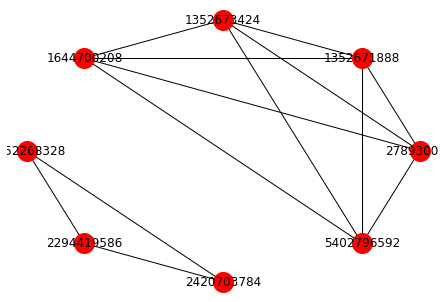

In [163]:
# ループの可視化
import networkx as nx
G = nx.Graph()
loop_states = [all_set_states[index] for index in indexes]
G.add_nodes_from(loop_states)
for state in loop_states:
    next_states = []
    for action in legal_actions(state):
        next_state = create_next_state(state, action)
        next_state = convert_normalization_state(next_state)
        next_states.append(next_state)
    for next_state in next_states:
        if next_state in loop_states:
            G.add_edges_from([(state, next_state)])

nx.draw_circular(G, node_size=400, node_color='red', with_labels=True)

2つのループに分けられる

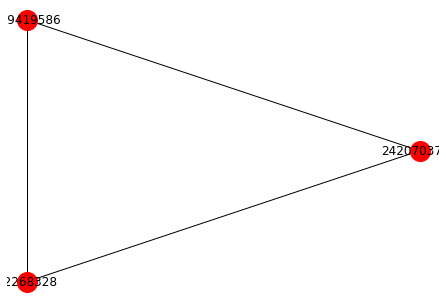

In [164]:
loop1 = [2420703784, 229419586, 52268328]
loop2 = [278930064, 1352671888, 1352673424, 1644700208, 5402796592]

G_l1 = nx.Graph()
G_l1.add_nodes_from(loop1)
for state1 in loop1:
    for state2 in loop1:
        if state1 != state2:
            G_l1.add_edges_from([(state1, state2)])
nx.draw_circular(G_l1, node_size=400, node_color='red', with_labels=True)

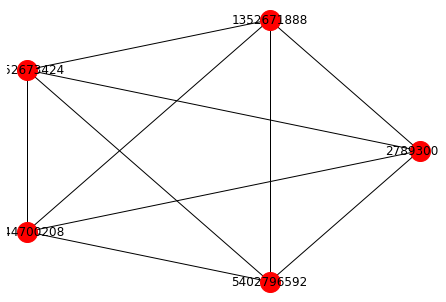

In [165]:
G_l2 = nx.Graph()
G_l2.add_nodes_from(loop2)
for state1 in loop2:
    for state2 in loop2:
        if state1 != state2:
            G_l2.add_edges_from([(state1, state2)])
nx.draw_circular(G_l2, node_size=400, node_color='red', with_labels=True)

In [166]:
loop1 = [2420703784, 229419586, 52268328]
loop2 = [278930064, 1352671888, 1352673424, 1644700208, 5402796592]
for loop in [loop1, loop2]:
    for state in loop:
        state = convert_normalization_state(state)
        print(f"{state:036b}")
    print()

000010010000010010010000001000101000
000000001101101011001010101001000010
000000000001101101001101100110000010

000000010000101000000010001010010000
000001010000101000000010001010010000
000001010000101000000010100010010000
000001100010000010000010001000110000
000101000010000010000010001000110000

